In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV3Small
import json
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO
import sys
import os


# Interactive widgets
from ipywidgets import widgets

In [2]:


# Add the parent directory to the Python path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(parent_dir)

# Now you can import the module
from src.utils.ml_utils import create_model

In [33]:
# Constants
IMG_SIZE = (224, 224)  # Image size (height, width)
BATCH_SIZE = 32  # Batch size

BASE_DIR = os.path.join(parent_dir, "artifacts", "data", "processed")
# Example Usage
train_dir = os.path.join(BASE_DIR, "train")
val_dir = os.path.join(BASE_DIR, "val")
test_dir = os.path.join(BASE_DIR, "test")

In [34]:
def parse_jsonl(jsonl_path):
    """
    Parse a JSONL file and yield image paths and labels.
    """
    with open(jsonl_path, "r") as f:
        for line in f:
            item = json.loads(line)
            yield item["image"], item["label"]


def load_datasets_from_directory(data_dir, batch_size=BATCH_SIZE, img_size=IMG_SIZE):
    """
    Create a combined tf.data.Dataset from JSONL files in a directory.
    Args:
        data_dir (str): Directory containing JSONL files for train, val, or test splits.
        batch_size (int): Batch size for the dataset.
        img_size (tuple): Target size for images (height, width).
    Returns:
        tf.data.Dataset: Combined TensorFlow dataset.
    """
    # Collect all JSONL files in the directory
    jsonl_files = [
        os.path.join(data_dir, fname)
        for fname in os.listdir(data_dir)
        if fname.endswith(".jsonl")
    ]

    # Helper function to load and parse one JSONL file
    def load_single_jsonl(jsonl_path):
        """
        Create a tf.data.Dataset from a single JSONL file.
        """

        def generator():
            # Parse JSONL into image paths and labels
            with open(jsonl_path, "r") as f:
                for line in f:
                    item = json.loads(line)
                    yield item["image"], item["label"]

        # Create a dataset for this JSONL file
        dataset = tf.data.Dataset.from_generator(
            generator, output_types=(tf.string, tf.int32), output_shapes=((), ())
        )
        return dataset

    # Combine all datasets using flat_map
    combined_dataset = None
    for jsonl_path in jsonl_files:
        single_dataset = load_single_jsonl(jsonl_path)
        combined_dataset = (
            single_dataset
            if combined_dataset is None
            else combined_dataset.concatenate(single_dataset)
        )

    # Preprocessing pipeline
    def preprocess(image_path, label):
        # Load and decode image
        try:
            image = tf.io.read_file(image_path)
            image = tf.image.decode_png(image, channels=3)
        except tf.errors.NotFoundError:
            print(f"File not found: {image_path.numpy().decode('utf-8')}")
            return None, None

        # Resize
        image = tf.image.resize(image, img_size)
        return image, label

    # Apply preprocessing, batching, and shuffling
    combined_dataset = (
        combined_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        .shuffle(buffer_size=1000)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

    return combined_dataset


train_dataset = load_datasets_from_directory(train_dir)
# Check the type
dataset_type = type(train_dataset)
print(
    f"train_dataset inherits from tf.data.Dataset: {issubclass(dataset_type, tf.data.Dataset)}"
)

val_dataset = load_datasets_from_directory(val_dir)
# Check the type
dataset_type = type(val_dataset)
print(
    f"val_dataset inherits from tf.data.Dataset: {issubclass(dataset_type, tf.data.Dataset)}"
)


test_dataset = load_datasets_from_directory(test_dir)

# Check the type
dataset_type = type(test_dataset)
print(
    f"test_dataset inherits from tf.data.Dataset: {issubclass(dataset_type, tf.data.Dataset)}"
)

# Example: Inspect a batch
for images, labels in train_dataset.take(1):
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels: {labels}")

train_dataset inherits from tf.data.Dataset: True
val_dataset inherits from tf.data.Dataset: True
test_dataset inherits from tf.data.Dataset: True
Batch of images shape: (32, 224, 224, 3)
Batch of labels: [1 1 1 1 1 0 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0 1 1]


In [35]:
def load_custom_image_dataset(directory, img_size=IMG_SIZE, batch_size=BATCH_SIZE):
    """
    Load a custom dataset of images organized by 'charts' and 'non_charts' subdirectories.

    Args:
        directory (str): Path to the directory containing images organized in subdirectories by label.
        img_size (tuple): Target size for images (height, width).
        batch_size (int): Number of images per batch.

    Returns:
        tf.data.Dataset: A TensorFlow dataset containing images and their labels.
        class_names (list): List of class names inferred from subdirectory names.
    """
    # Load dataset with labels inferred from directory structure
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        labels="inferred",  # Infer labels from subdirectory names
        label_mode="int",  # Return integer labels
        image_size=img_size,
        batch_size=batch_size,
        shuffle=True,
    )

    # Extract class names before transformations
    class_names = dataset.class_names

    return dataset, class_names


# Use it
custom_train_dir = train_dir
custom_train_dataset, class_names = load_custom_image_dataset(custom_train_dir)

custom_val_dir = val_dir
custom_val_dataset, _ = load_custom_image_dataset(custom_val_dir)

# Check the type
dataset_type = type(custom_train_dataset)
print(
    f"custom_train_dataset inherits from tf.data.Dataset: {issubclass(dataset_type, tf.data.Dataset)}"
)

# Check the type
dataset_type = type(custom_val_dataset)
print(
    f"custom_val_dataset inherits from tf.data.Dataset: {issubclass(dataset_type, tf.data.Dataset)}"
)


print(f"Class names: {class_names}")  # Output: ['charts', 'non_charts']

# Inspect the dataset
for images, labels in custom_train_dataset.take(1):
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels: {labels}")

Found 302 files belonging to 2 classes.


Found 45 files belonging to 2 classes.
custom_train_dataset inherits from tf.data.Dataset: True
custom_val_dataset inherits from tf.data.Dataset: True
Class names: ['charts', 'non_charts']
Batch of images shape: (32, 224, 224, 3)
Batch of labels: [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [36]:
train_dataset = train_dataset.concatenate(custom_train_dataset)
val_dataset = val_dataset.concatenate(custom_val_dataset)

# Example: Inspect a batch
for images, labels in train_dataset.take(1):
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels: {labels}")

Batch of images shape: (32, 224, 224, 3)
Batch of labels: [1 1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1]


In [37]:
list(train_dataset.take(1))[0]

(<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
 array([[[[2.51785717e+01, 8.17857170e+00, 1.17857146e+00],
          [2.51785717e+01, 8.17857170e+00, 1.17857146e+00],
          [2.41785717e+01, 7.17857170e+00, 1.78571463e-01],
          ...,
          [2.18214283e+01, 8.82142830e+00, 2.82142854e+00],
          [2.30000000e+01, 1.00000000e+01, 2.00000000e+00],
          [2.11785717e+01, 8.17857170e+00, 1.78571463e-01]],
 
         [[2.55357132e+01, 8.53571415e+00, 1.53571415e+00],
          [2.50825100e+01, 8.08250999e+00, 1.08250988e+00],
          [2.60714283e+01, 9.07142830e+00, 2.07142830e+00],
          ...,
          [1.99339676e+01, 6.93396854e+00, 9.33968425e-01],
          [2.19889660e+01, 8.98896503e+00, 9.88965452e-01],
          [2.10750904e+01, 8.07509041e+00, 5.63179970e-01]],
 
         [[2.60000000e+01, 9.00000000e+00, 2.00000000e+00],
          [2.51540184e+01, 8.15401840e+00, 1.15401840e+00],
          [2.68928566e+01, 9.89285755e+00, 2.89285755e+00],
    

In [38]:
# Get one batch from the dataset
image_batch, label_batch = list(train_dataset.take(1))[0]

# Check the shapes
print(f"image batch shape: {image_batch.shape}")
print(f"label batch shape: {label_batch.shape}")

image batch shape: (32, 224, 224, 3)
label batch shape: (32,)


In [39]:


# # Visualize a few samples
# for i in range(5):  # Display the first 5 images in the batch
#     plt.imshow(image_batch[i].numpy().astype("uint8"))
#     plt.title(f"Label: {label_batch[i]}")
#     plt.axis("off")
#     plt.show()

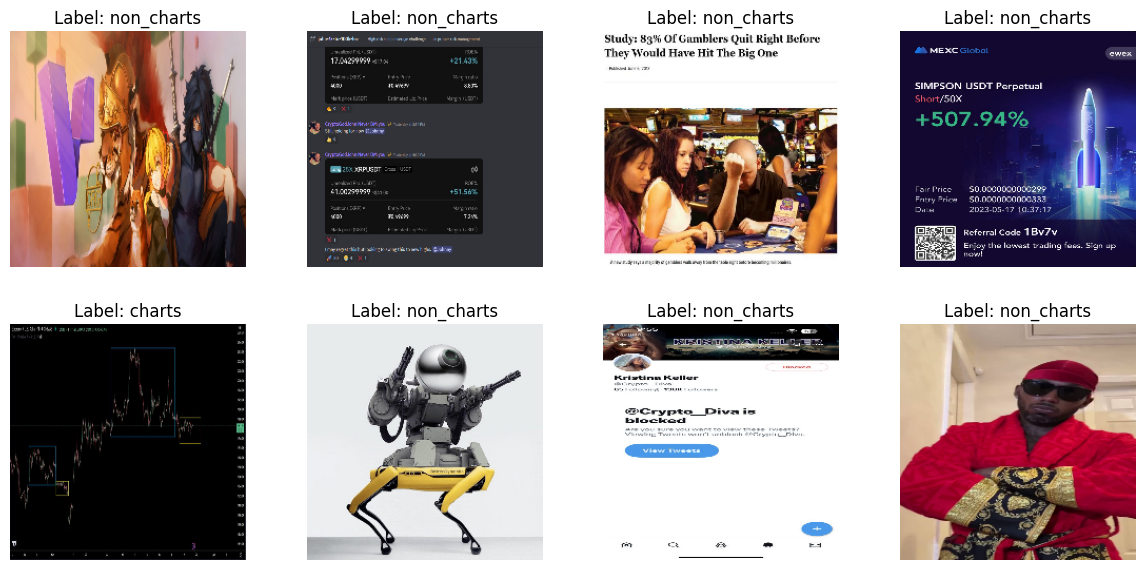

In [10]:
def plot_image_grid(images, labels, class_names, rows=2, cols=4):
    """
    Plot a tight grid of randomly selected images with their labels.

    Args:
        images (numpy.ndarray): Batch of images to display.
        labels (numpy.ndarray): Corresponding labels.
        class_names (list): Class names for labels.
        rows (int): Number of rows in the grid.
        cols (int): Number of columns in the grid.
    """
    # Shuffle the indices
    indices = np.random.permutation(len(images))
    selected_images = images[indices[: rows * cols]]
    selected_labels = labels[indices[: rows * cols]]

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    fig.tight_layout(pad=1.0)

    for i, ax in enumerate(axes.flat):
        if i >= len(selected_images):
            break
        ax.imshow(selected_images[i].astype("uint8"))
        ax.set_title(f"Label: {class_names[selected_labels[i]]}")
        ax.axis("off")

    plt.show()


# Convert tensors to numpy arrays for visualization
image_batch_np = image_batch.numpy()
label_batch_np = label_batch.numpy()

# Class names for labels
class_names = ["charts", "non_charts"]

# Plot the grid
plot_image_grid(image_batch_np, label_batch_np, class_names, rows=2, cols=4)

In [11]:
print(image_batch[0].numpy())

[[[30. 34. 45.]
  [30. 34. 45.]
  [30. 34. 45.]
  ...
  [30. 34. 45.]
  [30. 34. 45.]
  [30. 34. 45.]]

 [[30. 34. 45.]
  [30. 34. 45.]
  [30. 34. 45.]
  ...
  [30. 34. 45.]
  [30. 34. 45.]
  [30. 34. 45.]]

 [[30. 34. 45.]
  [30. 34. 45.]
  [30. 34. 45.]
  ...
  [30. 34. 45.]
  [30. 34. 45.]
  [30. 34. 45.]]

 ...

 [[30. 34. 45.]
  [30. 34. 45.]
  [30. 34. 45.]
  ...
  [30. 34. 45.]
  [30. 34. 45.]
  [30. 34. 45.]]

 [[30. 34. 45.]
  [30. 34. 45.]
  [30. 34. 45.]
  ...
  [30. 34. 45.]
  [30. 34. 45.]
  [30. 34. 45.]]

 [[30. 34. 45.]
  [30. 34. 45.]
  [30. 34. 45.]
  ...
  [30. 34. 45.]
  [30. 34. 45.]
  [30. 34. 45.]]]


In [12]:
print(label_batch.numpy())

[0 1 0 1 1 1 1 0 0 1 1 0 0 0 1 1 1 1 0 0 1 1 1 0 1 1 1 0 0 1 0 1]


In [13]:
# Check the range of values
print(f"max value: {np.max(image_batch[0].numpy())}")
print(f"min value: {np.min(image_batch[0].numpy())}")

max value: 255.0
min value: 3.892822265625


In [14]:
rescale_layer = tf.keras.layers.Rescaling(scale=1.0 / 255)

In [15]:
image_scaled = rescale_layer(image_batch[20]).numpy()

print(image_scaled)

[[[0.0000000e+00 0.0000000e+00 3.7722124e-03]
  [4.8162043e-03 4.8162043e-03 6.4356029e-03]
  [9.2379535e-03 7.7919854e-04 4.0998533e-02]
  ...
  [7.4509807e-02 3.1372551e-02 1.8823531e-01]
  [7.4509807e-02 3.1372551e-02 1.8823531e-01]
  [7.4509807e-02 3.1372551e-02 1.8823531e-01]]

 [[0.0000000e+00 0.0000000e+00 6.4950986e-03]
  [1.8904150e-02 5.0877011e-03 7.9304822e-02]
  [6.6666670e-02 4.0966388e-02 1.6139694e-01]
  ...
  [7.4509807e-02 3.1372551e-02 1.8823531e-01]
  [7.4509807e-02 3.1372551e-02 1.8823531e-01]
  [7.4509807e-02 3.1372551e-02 1.8823531e-01]]

 [[6.0165278e-03 4.3480276e-04 1.9021360e-02]
  [6.7340828e-02 3.9215688e-02 1.6994064e-01]
  [7.4509807e-02 3.4742650e-02 1.8149512e-01]
  ...
  [7.4509807e-02 3.1372551e-02 1.8823531e-01]
  [7.4509807e-02 3.1372551e-02 1.8823531e-01]
  [7.4509807e-02 3.1372551e-02 1.8823531e-01]]

 ...

 [[7.4509807e-02 3.1372551e-02 1.8823531e-01]
  [7.4509807e-02 3.1372551e-02 1.8823531e-01]
  [7.4509807e-02 3.1372551e-02 1.8823531e-01]
  ..

In [16]:
print(f"max value: {np.max(image_scaled)}")
print(f"min value: {np.min(image_scaled)}")

max value: 1.0
min value: 0.0


In [17]:
def normalize_dataset(dataset):
    """
    Normalize a tf.data.Dataset using a Rescaling layer.
    Args:
        dataset: The tf.data.Dataset to normalize.
    Returns:
        A normalized tf.data.Dataset.
    """
    return dataset.map(
        lambda image, label: (rescale_layer(image), label),
        num_parallel_calls=tf.data.AUTOTUNE,
    ).prefetch(tf.data.AUTOTUNE)


# Normalize datasets
train_dataset_scaled = normalize_dataset(train_dataset)
val_dataset_scaled = normalize_dataset(val_dataset)
test_dataset_scaled = normalize_dataset(test_dataset)

In [18]:
# Get one batch of data
sample_batch = list(train_dataset_scaled.take(1))[0]

# Get the image
image_scaled = sample_batch[0][10].numpy()

# Check the range of values for this image
print(f"max value: {np.max(image_scaled)}")
print(f"min value: {np.min(image_scaled)}")

max value: 1.0
min value: 0.0


In [19]:
model, model_file_name = create_model("mobile")
# model, model_file_name = create_model("custom-1")
# model, model_file_name = create_model("resnet")
# model, model_file_name = create_model("efficientnet")
# model, model_file_name = create_model("densenet")
#model, model_file_name = create_model("mobile_large")

# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,013,105 (3.86 MB)

 Trainable params: 73,985 (289.00 KB)

 Non-trainable params: 939,120 (3.58 MB)

In [20]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_dataset_final = (
    train_dataset_scaled.cache()
    .shuffle(SHUFFLE_BUFFER_SIZE)
    .prefetch(PREFETCH_BUFFER_SIZE)
)

# Configure the validation dataset
validation_dataset_final = val_dataset_scaled.cache().prefetch(
    PREFETCH_BUFFER_SIZE
)

# Configure the test dataset
test_dataset_final = test_dataset_scaled.cache().prefetch(PREFETCH_BUFFER_SIZE)

In [21]:
save_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("..", "models", model_file_name),
    monitor="val_loss",
    save_best_only=True,
    verbose=1,
)

In [27]:
history = model.fit(
    train_dataset_final,
    validation_data=validation_dataset_final,
    epochs=30,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True), save_checkpoint],
    verbose=1,
)

Epoch 1/30
    301/Unknown 24s 80ms/step - accuracy: 0.9054 - auc: 0.9492 - loss: 0.2663
Epoch 1: val_loss improved from 0.24259 to 0.23580, saving model to ../models/mobilenetv3_classifier.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 29s 97ms/step - accuracy: 0.9054 - auc: 0.9492 - loss: 0.2663 - val_accuracy: 0.9284 - val_auc: 0.9563 - val_loss: 0.2358
Epoch 2/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9140 - auc: 0.9471 - loss: 0.2467
Epoch 2: val_loss did not improve from 0.23580
301/301 ━━━━━━━━━━━━━━━━━━━━ 30s 100ms/step - accuracy: 0.9140 - auc: 0.9471 - loss: 0.2467 - val_accuracy: 0.9244 - val_auc: 0.9571 - val_loss: 0.2493
Epoch 3/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9086 - auc: 0.9495 - loss: 0.2627
Epoch 3: val_loss improved from 0.23580 to 0.23579, saving model to ../models/mobilenetv3_classifier.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 30s 100ms/step - accuracy: 0.9086 - auc: 0.9495 - loss: 0.2627 - val_accuracy: 0.9156 - val_auc: 0.9581 - val_loss: 

2025-01-26 08:38:56.004704: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 9: val_loss did not improve from 0.21667
301/301 ━━━━━━━━━━━━━━━━━━━━ 22s 72ms/step - accuracy: 0.9226 - auc: 0.9572 - loss: 0.2312 - val_accuracy: 0.8999 - val_auc: 0.9630 - val_loss: 0.2568
Epoch 10/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9198 - auc: 0.9550 - loss: 0.2387
Epoch 10: val_loss improved from 0.21667 to 0.21430, saving model to ../models/mobilenetv3_classifier.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 22s 72ms/step - accuracy: 0.9198 - auc: 0.9550 - loss: 0.2388 - val_accuracy: 0.9264 - val_auc: 0.9630 - val_loss: 0.2143
Epoch 11/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9180 - auc: 0.9542 - loss: 0.2381
Epoch 11: val_loss did not improve from 0.21430
301/301 ━━━━━━━━━━━━━━━━━━━━ 22s 72ms/step - accuracy: 0.9180 - auc: 0.9542 - loss: 0.2381 - val_accuracy: 0.8935 - val_auc: 0.9644 - val_loss: 0.2727
Epoch 12/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9190 - auc: 0.9613 - loss: 0.2252
Epoch 12: val_loss did not improve fr

In [28]:
# Save the model --  See save_checkpoint
# model.save(model_file_name)

# model.export("../models/mobilenetv3_classifier_serving")

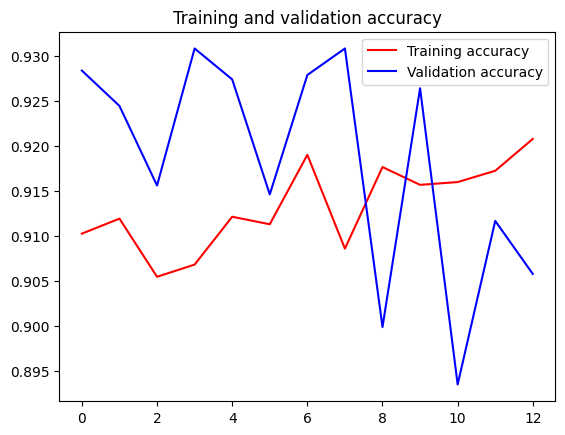

In [29]:
# Plot the training and validation accuracies for each epoch

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))

plt.plot(epochs, acc, "r", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend(loc=0)
plt.show()

In [30]:
test_loss, test_accuracy, test_auc = model.evaluate(test_dataset_final)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC: {test_auc}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9288 - auc: 0.9744 - loss: 0.2031
Test Loss: 0.2085368037223816
Test Accuracy: 0.9258888363838196
Test AUC: 0.9632813930511475


In [31]:


# Create the widget and take care of the display
uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)
out = widgets.Output()
display(out)


def file_predict(filename, file, out):
    """A function for creating the prediction and printing the output."""
    image = tf.keras.utils.load_img(file, target_size=IMG_SIZE)
    image = tf.keras.utils.img_to_array(image)
    image = rescale_layer(image)
    image = np.expand_dims(image, axis=0)

    prediction = model.predict(image, verbose=0)[0][0]

    with out:
        if prediction <= 0.5:
            print(filename + " is a chart")
        else:
            print(filename + " is not a chart")


def on_upload_change(change):
    """A function for geting files from the widget and running the prediction."""
    # Get the newly uploaded file(s)

    items = change.new
    for item in items:  # Loop if there is more than one file uploaded
        file_jpgdata = BytesIO(item.content)
        file_predict(item.name, file_jpgdata, out)


# Run the interactive widget
# Note: it may take a bit after you select the image to upload and process before you see the output.
uploader.observe(on_upload_change, names="value")

FileUpload(value=(), accept='image/*', description='Upload', multiple=True)

Output()

In [32]:
# Shutdown the kernel to free up resources.
# Note: You can expect a pop-up when you run this cell. You can safely ignore that and just press `Ok`.

# from IPython import get_ipython

# k = get_ipython().kernel

# k.do_shutdown(restart=False)